In [1]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376098 sha256=4b5aa6abe737888bcd0d6192e1308abf9d3f4abfc4ee166bee6fae28297f65e7
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.0003
NUM_EPISODES = 500
HORIZON = 2048

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:


class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)

        self.policy_logits = nn.Linear(512, num_actions)
        self.value = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.policy_logits(x), self.value(x)







In [4]:
env = gym.make('CartPole-v1')
input_shape = 4
num_actions = env.action_space.n

policy = ActorCritic(input_shape, num_actions).to(device)
optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)

episode_rewards = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()

    log_probs = []
    values = []
    rewards = []
    masks = []

    total_reward = 0

    for t in range(HORIZON):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits, value = policy(state_tensor)
        probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(probs, 1).item()

        next_state, reward, done, _, _ = env.step(action)

        log_prob = torch.log_softmax(logits, dim=-1)[0, action]

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1 - done], dtype=torch.float, device=device))

        state = next_state
        total_reward += reward

        if done:
            break

    episode_rewards.append(total_reward)

    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    _, next_value = policy(next_state_tensor)

    rewards = torch.cat(rewards).to(device)
    masks = torch.cat(masks).to(device)
    returns = torch.zeros_like(rewards).to(device)

    R = next_value
    for i in reversed(range(len(rewards))):
        R = rewards[i] + GAMMA * R * masks[i]
        returns[i] = R

    log_probs = torch.stack(log_probs)
    values = torch.stack(values).squeeze()

    advantage = returns - values

    policy_loss = -(log_probs * advantage.detach()).mean()
    value_loss = advantage.pow(2).mean()

    loss = policy_loss + 0.5 * value_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Episode {episode + 1}, Total reward: {total_reward}")

env.close()


Episode 1, Total reward: 38.0
Episode 2, Total reward: 14.0
Episode 3, Total reward: 10.0
Episode 4, Total reward: 29.0
Episode 5, Total reward: 13.0
Episode 6, Total reward: 18.0
Episode 7, Total reward: 13.0
Episode 8, Total reward: 11.0
Episode 9, Total reward: 17.0
Episode 10, Total reward: 30.0
Episode 11, Total reward: 20.0
Episode 12, Total reward: 32.0
Episode 13, Total reward: 12.0
Episode 14, Total reward: 19.0
Episode 15, Total reward: 22.0
Episode 16, Total reward: 34.0
Episode 17, Total reward: 14.0
Episode 18, Total reward: 13.0
Episode 19, Total reward: 16.0
Episode 20, Total reward: 13.0
Episode 21, Total reward: 35.0
Episode 22, Total reward: 12.0
Episode 23, Total reward: 18.0
Episode 24, Total reward: 11.0
Episode 25, Total reward: 15.0
Episode 26, Total reward: 9.0
Episode 27, Total reward: 13.0
Episode 28, Total reward: 34.0
Episode 29, Total reward: 19.0
Episode 30, Total reward: 32.0
Episode 31, Total reward: 15.0
Episode 32, Total reward: 20.0
Episode 33, Total 

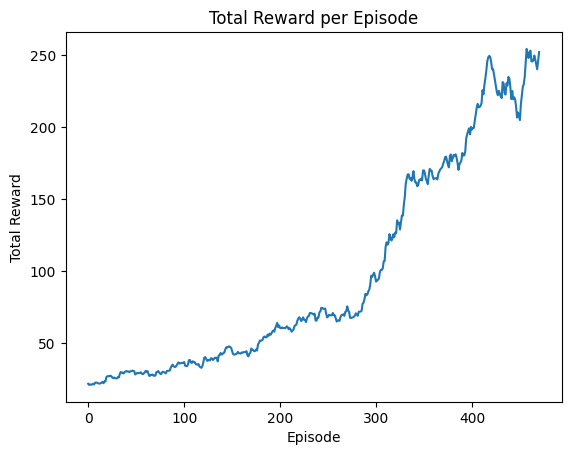

In [ ]:
def moving_average(data, window_size):
    """
    Calculate the moving average of a given list of numbers.

    Parameters:
    - data: List of numbers.
    - window_size: Size of the moving window.

    Returns:
    - List of moving averages.
    """
    if len(data) < window_size:
        return []

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = sum(window) / window_size
        moving_averages.append(window_average)

    return moving_averages

ma = moving_average(episode_rewards,30)

# Plot cumulative rewards
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()